In [1]:
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
import scanpy.external as sce
from itertools import islice, cycle
from sklearn.preprocessing import normalize

from ALLCools.clustering import tsne, significant_pc_test, filter_regions, remove_black_list_region, lsi, binarize_matrix
from ALLCools.plot import *

In [2]:
indir = '/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCAD/'
metadata_path = f'{indir}AllMpgSmries_Rep1Rep2_HIV_Samples_Only_withFullSampleLabel_allCLoc_RmvExtrCma_withHdr.csv.gz'

HIVmeta = pd.read_csv(metadata_path, index_col=0).sort_index()
HIVmeta[['HIV', 'sampleID', 'replicate', 'wellID', 'cell_type', 'condition']]=HIVmeta.SampleInfo.str.split("_", expand=True)
HIVmeta['sampleID'] = HIVmeta['sampleID'].apply(lambda x: "HIV_" + str(x))
HIVmeta['replicate'] = HIVmeta['replicate'].apply(lambda x: re.sub("R", "Rep", x))
HIVmeta['exposure'] = ['HIV_pre' if x == 'pre' else 'HIV' for x in HIVmeta['condition']]
HIVmeta['Sex'] = 'Male'
HIVmeta['MappingRate'] = (HIVmeta['R1MappedRatio'] + HIVmeta['R2MappedRatio'])/2.0
HIVmeta['FinalmCReads'] = HIVmeta['DeduppedReads']
HIVmeta['mCGFrac'] = HIVmeta['CG_Rate']
print(f'Metadata of {HIVmeta.shape[0]} cells')
pd.set_option('display.max_columns', None)
HIVmeta.index = HIVmeta['SampleInfo']
HIVmeta.head()

Metadata of 19165 cells


index_name  MultiplexReadsTotal  IndexReadsTotal  \
SampleInfo                                                                    
HIV_1_R1_A0_Other-cell_pre      ad001             34255590          4031068   
HIV_1_R1_B0_Other-cell_pre      ad002             34255590          5012910   
HIV_1_R1_A1_Other-cell_pre      ad004             34255590          5243094   
HIV_1_R1_B1_Other-cell_pre      ad006             34255590          5587534   
HIV_3_R1_A0_Other-cell_cro      ad007             34255590          4367786   

                            IndexReadsRatio  IndexBpTotal  IndexTrimedBpTotal  \
SampleInfo                                                                      
HIV_1_R1_A0_Other-cell_pre        11.767621     579804493           496571353   
HIV_1_R1_B0_Other-cell_pre        14.633845     720556253           616844650   
HIV_1_R1_A1_Other-cell_pre        15.305806     754961219           646710720   
HIV_1_R1_B1_Other-cell_pre        16.311306     798640481           682753797   
HIV_3_R1_A0_Other-cell_cro        12.750579     633609127           544084360   

                            IndexTrimedReadsTotal  ReadsQualTrimBpTotal  \
SampleInfo                                                                
HIV_1_R1_A0_Other-cell_pre                3920896               1127041   
HIV_1_R1_B0_Other-cell_pre                4864419               1414577   
HIV_1_R1_A1_Other-cell_pre                5103260               1400092   
HIV_1_R1_B1_Other-cell_pre                5390298               1497622   
HIV_3_R1_A0_Other-cell_cro                4294245               1151022   

                            ReadsLengthFilterTotal  ReadsWithAdapterTotal  \
SampleInfo                                                                  
HIV_1_R1_A0_Other-cell_pre                  110172                   9327   
HIV_1_R1_B0_Other-cell_pre                  148491                  24979   
HIV_1_R1_A1_Other-cell_pre                  139834                  20650   
HIV_1_R1_B1_Other-cell_pre                  197236                  29168   
HIV_3_R1_A0_Other-cell_cro                   73541                   4971   

                            TrimedReadsAveLength  IndexTrimedReadsRatio  \
SampleInfo                                                                
HIV_1_R1_A0_Other-cell_pre            126.647418               0.972669   
HIV_1_R1_B0_Other-cell_pre            126.807467               0.970378   
HIV_1_R1_A1_Other-cell_pre            126.725019               0.973330   
HIV_1_R1_B1_Other-cell_pre            126.663460               0.964701   
HIV_3_R1_A0_Other-cell_cro            126.700819               0.983163   

                               CTOB     CTOT  R1MappedRatio  R1TotalC  \
SampleInfo                                                              
HIV_1_R1_A0_Other-cell_pre   749499   753429           76.7  38971840   
HIV_1_R1_B0_Other-cell_pre   955157   951909           78.4  49214608   
HIV_1_R1_A1_Other-cell_pre   984943   986060           77.3  50615438   
HIV_1_R1_B1_Other-cell_pre  1004493  1005187           74.6  51367294   
HIV_3_R1_A0_Other-cell_cro   822138   823609           76.7  42447444   

                            R1TrimmedReads  R1UniqueMappedReads  \
SampleInfo                                                        
HIV_1_R1_A0_Other-cell_pre         1959825              1502928   
HIV_1_R1_B0_Other-cell_pre         2431668              1907070   
HIV_1_R1_A1_Other-cell_pre         2550914              1971003   
HIV_1_R1_B1_Other-cell_pre         2694362              2009680   
HIV_3_R1_A0_Other-cell_cro         2146736              1645747   

                            R1UnmappedReads  R1UnuniqueMappedReads      OB  \
SampleInfo                                                                   
HIV_1_R1_A0_Other-cell_pre           324193                 132704  691878   
HIV_1_R1_B0_Other-cell_pre           354156                 170442  867641   
HIV_1_R1_A1_Other-c

In [4]:
metadata_path = '/gale/netapp/DoD/wenliang/projects/02.MRSA/02.clustering/02.5K/CellMetadata.PassQC.csv.gz'
MRSAmeta = pd.read_csv(metadata_path, index_col='cell')
sampleInfo = pd.read_csv("/gale/netapp/DoD/wenliang/projects/02.MRSA/00.data/combined.metadata.tsv", sep="\t")
sampleInfo['SampleID'] = ['MRSA_' + str(x) for x in sampleInfo['SampleID']]
id2cohort = dict(zip(sampleInfo['SampleID'], sampleInfo['Cohort']))
id2donor = dict(zip(sampleInfo['SampleID'], sampleInfo['donorID']))
id2Sex = dict(zip(sampleInfo['SampleID'], sampleInfo['Gender']))
id2Age = dict(zip(sampleInfo['SampleID'], sampleInfo['Age']))
id2Race = dict(zip(sampleInfo['SampleID'], sampleInfo['Race']))
# for plate, sub_df in MRSAmeta.groupby('real_plate'):
#     if plate.startswith("Ctrl"):
#         sampleID = "_".join(plate.split("_")[0:2])
#         id2cohort[sampleID] = 'Ctrl'
MRSAmeta['sampleID'] = ["_".join(x.split("_")[0:2]) for x in MRSAmeta['real_plate']]
MRSAmeta['FinalmCReads'] = MRSAmeta['DeduppedReads']
MRSAmeta['mCGFrac'] = MRSAmeta['CG_Rate']

wellID2cell = pd.read_csv("/gale/netapp/DoD/wenliang/projects/02.MRSA/00.data/wellID2cell.tsv", sep="\t", names=['well', 'cell'])
well2cell = dict(zip(wellID2cell['well'], wellID2cell['cell']))
MRSAmeta['cell_type'] = [well2cell[x] for x in MRSAmeta['Pos384']]

Ctrl_info = pd.read_csv("/gale/netapp/DoD/wenliang/projects/02.MRSA/00.data/Ctrl.metadata.tsv", sep="\t")
Ctrl_info["PlateID"] = ["Ctrl_" + str(x) for x in Ctrl_info['PlateID']]
id2Sex.update(dict(zip(Ctrl_info['PlateID'], Ctrl_info['Gender'])))
id2Age.update(dict(zip(Ctrl_info['PlateID'], Ctrl_info['Age'])))
id2Race.update(dict(zip(Ctrl_info['PlateID'], Ctrl_info['Race'])))
for i, row in Ctrl_info.iterrows():
    id2cohort[row.PlateID] = 'Ctrl'

E24E25 = pd.read_csv("../02.MRSA/00.data/E24E25.metadata.csv", index_col=0)
E24E25['sampleID'] = ["_".join(x.split("_")[0:2]) for x in E24E25['sampleID']]
E24E25['MappingRate'] = (E24E25['R2MappingRate'] + E24E25['R2MappingRate'])/2.0
MRSAmeta = pd.concat([MRSAmeta, E24E25])

MRSAmeta['Sex'] = [id2Sex[x] for x in MRSAmeta['sampleID']]
MRSAmeta['Age'] = [id2Age[x] for x in MRSAmeta['sampleID']]
MRSAmeta['exposure'] = [id2cohort[x] for x in MRSAmeta['sampleID']]
MRSAmeta['DonorID'] = [id2donor[x] if x in id2donor else x for x in MRSAmeta['sampleID']]
print(f'Metadata of {MRSAmeta.shape[0]} cells')

Metadata of 19019 cells


In [5]:
metadata_path = '/gale/netapp/DoD/wenliang/projects/06.Flu/02.clustering/02.5K/CellMetadata.PassQC.csv.gz'
Flumeta = pd.read_csv(metadata_path, index_col=0)

alphabet_string = string.ascii_uppercase
alphabet_list = list(alphabet_string)
abc = alphabet_list[0:16]
num = list(range(16))
num2abc = dict(zip(num, abc))

wellID2cell = pd.read_csv("/gale/netapp/DoD/wenliang/projects/06.Flu/00.data/wellID2cell.tsv", sep="\t", names=['well', 'cell'])
well2cell = dict(zip(wellID2cell['well'], wellID2cell['cell']))

rowIDs = [num2abc[x] for x in Flumeta['Row384']]
colIDs = Flumeta['Col384'].to_list()
wellIDs = [str(rowIDs[x]) + str(colIDs[x]) for x in range(len(rowIDs))]
Flumeta['cell_type'] = [well2cell[x] for x in wellIDs]
Flumeta['sampleID'] = [re.sub("_[1-9]$", "", x) for x in Flumeta['Plate']]
sampleInfo = pd.read_csv("/gale/netapp/DoD/wenliang/projects/06.Flu/00.data/metadata.tsv", sep="\t")
sampleInfo['Visit'] = ["Flu_pre" if x == "D1" else 'Flu_pos' for x in sampleInfo['Visit']]
id2group = dict(zip(sampleInfo['Sample'], sampleInfo['Visit']))
Flumeta['exposure'] = [id2group[x] for x in Flumeta['sampleID']]
Flumeta.head()

Plate PCRIndex  MultiplexGroup RandomIndex  Col384  \
Flu_18_1-6-M17-A11  Flu_18_1      M17               6         A11      10   
Flu_18_1-6-M17-A12  Flu_18_1      M17               6         A12      11   
Flu_18_1-6-M17-A23  Flu_18_1      M17               6         A23      22   
Flu_18_1-6-M17-A24  Flu_18_1      M17               6         A24      23   
Flu_18_1-6-M17-B11  Flu_18_1      M17               6         B11      10   

                    Row384  R1InputReads  R1InputReadsBP  R1WithAdapters  \
Flu_18_1-6-M17-A11       0       1599394       222904045            1601   
Flu_18_1-6-M17-A12       0       1709662       237724094            2189   
Flu_18_1-6-M17-A23       0       1705306       236965967            1550   
Flu_18_1-6-M17-A24       0       1574805       220615926            1275   
Flu_18_1-6-M17-B11       1       1375381       192497761            1423   

                    R1QualTrimBP  R1TrimmedReads  R1TrimmedReadsBP  \
Flu_18_1-6-M17-A11        417934         1588818         190296439   
Flu_18_1-6-M17-A12        499919         1694512         202785510   
Flu_18_1-6-M17-A23        453545         1694673         202193644   
Flu_18_1-6-M17-A24        386997         1568191         188602057   
Flu_18_1-6-M17-B11        413709         1368291         164431165   

                    R1TrimmedReadsRate  R1UniqueMappedReads  R1MappingRate  \
Flu_18_1-6-M17-A11            0.993387              1140505           71.8   
Flu_18_1-6-M17-A12            0.991139              1164287           68.7   
Flu_18_1-6-M17-A23            0.993765              1149366           67.8   
Flu_18_1-6-M17-A24            0.995800              1059583           67.6   
Flu_18_1-6-M17-B11            0.994845               990780           72.4   

                    R1UnmappedReads  R1UnuniqueMappedReads  R1OT  R1OB  \
Flu_18_1-6-M17-A11           348586                  99727     0     0   
Flu_18_1-6-M17-A12           426183                 104042     0     0   
Flu_18_1-6-M17-A23           445354                  99953     0     0   
Flu_18_1-6-M17-A24           409528                  99080     0     0   
Flu_18_1-6-M17-B11           296265                  81246     0     0   

                    R1CTOT  R1CTOB  R1TotalC  R1TotalmCGRate  R1TotalmCHGRate  \
Flu_18_1-6-M17-A11  570218  570286  28840045            71.8              0.9   
Flu_18_1-6-M17-A12  583376  580911  29465852            74.1              1.5   
Flu_18_1-6-M17-A23  574637  574724  29124329            67.6              0.8   
Flu_18_1-6-M17-A24  530963  528620  26918904            79.5              0.7   
Flu_18_1-6-M17-B11  495853  494926  25441112            69.5              0.8   

                    R1TotalmCHHRate  R1MAPQFilteredReads  R1DuplicatedReads  \
Flu_18_1-6-M17-A11              0.7              1030224             312075   
Flu_18_1-6-M17-A12              1.3              1048633             318263   
Flu_18_1-6-M17-A23              0.6              1073605             318613   
Flu_18_1-6-M17-A24              0.6               986675             300194   
Flu_18_1-6-M17-B11              0.7               890141             265661   

                    R1DuplicationRate  R1FinalBismarkReads  R2InputReads  \
Flu_18_1-6-M17-A11           0.302920               718149       1599394   
Flu_18_1-6-M17-A12           0.303503               730370       1709662   
Flu_18_1-6-M17-A23           0.296769               754992       1705306   
Flu_18_1-6-M17-A24           0.304248               686481       1574805   
Flu_18_1-6-M17-B11           0.298448               624480       1375381   

                    R2InputReadsBP  R2WithAdapters  R2QualTrimBP  \
Flu_18_1-6-M17-A11       235688101           19820        455685   
Flu_18_1-6-M17-A12       251008218           25005        525002   
Flu_18_1-6-M17-A23       250656779           20037        479191   
Flu_18_1-6-M17-A24       233194899           19016        464114   
Flu_18_1-

In [6]:
metadata = pd.concat([HIVmeta, MRSAmeta, Flumeta])
HIV_Ctrl = metadata[metadata['exposure']=='HIV_pre']
MRSA_Ctrl = metadata[metadata['exposure']=='Ctrl']
Flu_Ctrl =  metadata[metadata['exposure']=='Flu_pre']

In [7]:
Ctrl_metadata = pd.concat([HIV_Ctrl, MRSA_Ctrl, Flu_Ctrl])

## 0.0 filter  cells

In [8]:
mapping_rate_cutoff = 50
final_reads_cutoff = 500000
mcg_cutoff = 0.5

19137 / 21186 cells (90.3%) passed the MappingRate cutoff 50.


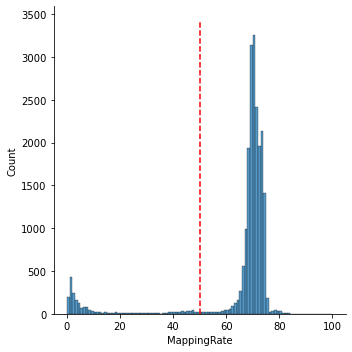

In [11]:
_cutoff = mapping_rate_cutoff
_col_name = 'MappingRate'

metadata=Ctrl_metadata

# plot distribution to make sure cutoff is appropriate
g = sns.displot(metadata[_col_name], binrange=(0, 100), bins=100)
g.ax.plot((_cutoff, _cutoff), g.ax.get_ylim(), c='r', linestyle='--')
g.savefig("MappingRateQC.pdf")

mapping_rate_judge = metadata[_col_name] > _cutoff
_passed_cells = mapping_rate_judge.sum()
total_cell = metadata.shape[0]
print(
    f'{_passed_cells} / {total_cell} cells ({_passed_cells / total_cell * 100:.1f}%) '
    f'passed the {_col_name} cutoff {_cutoff}.')

18602 / 21186 cells (87.8%) passed the FinalmCReads cutoff 500000.


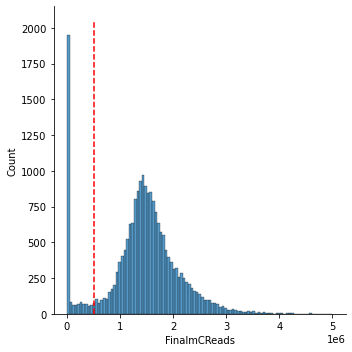

In [13]:
_cutoff = final_reads_cutoff
_col_name = 'FinalmCReads'

metadata['FinalmCReads'] = metadata.apply(lambda row: row['DeduppedReads'] if row['FinalmCReads']==np.nan else row['FinalmCReads'], axis=1)
total_cells= metadata.shape[0]
# plot distribution to make sure cutoff is appropriate
g = sns.displot(metadata[_col_name], binrange=(0, 5e6))
g.ax.plot((_cutoff, _cutoff), g.ax.get_ylim(), c='r', linestyle='--')
g.savefig("FinalmCReadsQC.pdf")

final_reads_judge = metadata[_col_name] > _cutoff
_passed_cells = final_reads_judge.sum()
print(
    f'{_passed_cells} / {total_cells} cells ({_passed_cells / total_cells * 100:.1f}%) '
    f'passed the {_col_name} cutoff {_cutoff}.')

21139 / 21186 cells (99.8%) passed the mCGFrac cutoff 0.5.


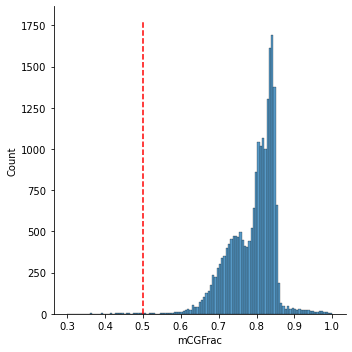

In [14]:
_cutoff = mcg_cutoff
_col_name = 'mCGFrac'

# plot distribution to make sure cutoff is appropriate
g = sns.displot(metadata[_col_name], binrange=(0.3, 1))
g.ax.plot((_cutoff, _cutoff), g.ax.get_ylim(), c='r', linestyle='--')
g.savefig("mCGFracQC.pdf")

mcg_judge = metadata[_col_name] > _cutoff
_passed_cells = mcg_judge.sum()
print(
    f'{_passed_cells} / {total_cells} cells ({_passed_cells / total_cells * 100:.1f}%) '
    f'passed the {_col_name} cutoff {_cutoff}.')

In [19]:
judge = mapping_rate_judge & final_reads_judge & mcg_judge
passed_cells = judge.sum()
print(
    f'{passed_cells} / {total_cells} cells ({passed_cells / total_cells * 100:.1f}%) '
    f'passed all the filters.')

18295 / 21186 cells (86.4%) passed all the filters.


In [20]:
metadata_filtered = metadata[judge].copy()
metadata_filtered.index.name='cell'
metadata_filtered.to_csv('CellMetadata.PassQC.csv.gz')

In [21]:
metadata = metadata_filtered

## 0.1 Basic functions and parameters

In [7]:
def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f'{name}_{i}'] = adata.obsm[f'X_{name}'][:, i]
    return adata

In [8]:
pc_cutoff = 0.1
knn = -1  # -1 means auto determine
# Leiden
resolution = 0.5

In [9]:
mcad = anndata.read_h5ad("HIVpre_Flupre_Ctrl.withTSNE.h5ad")

## 1. read MCAD

In [61]:
mcad_path_list = [
             '/gale/netapp/DoD/wenliang/projects/02.MRSA/02.clustering/00.data/MRSA.mcad',
             '/gale/netapp/DoD/wenliang/projects/06.Flu/02.clustering/00.data/Flu.mcad']

In [62]:
mcad_list = []
for mcad_path in mcad_path_list:
    tmp = anndata.read_h5ad(mcad_path)
    binarize_matrix(tmp, cutoff=0.95)
    mcad_list.append(tmp)

In [63]:
convert_id = pd.read_csv("/gale/netapp/DoD/wenliang/projects/01.HIV/binid_convert.tab", names=['manoj', 'wenliang'], sep="\t")
convert_id = dict(zip(convert_id['manoj'], convert_id['wenliang']))

In [64]:
HIV_mcad_list = ['/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCAD/MCAD_5kb_Other-cell_CGN_StrndMrgd_allC.mcad',
             '/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCAD/MCAD_5kb_Tc-Mem_CGN_StrndMrgd_allC.mcad',
             '/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCAD/MCAD_5kb_Th-Mem_CGN_StrndMrgd_allC.mcad',
             '/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCAD/MCAD_5kb_Tc-Naive_CGN_StrndMrgd_allC.mcad',
             '/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCAD/MCAD_5kb_Th-Naive_CGN_StrndMrgd_allC.mcad',
             '/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCAD/MCAD_5kb_Monocyte_CGN_StrndMrgd_allC.mcad',
             '/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCAD/MCAD_5kb_B-cell_CGN_StrndMrgd.mcad',
             '/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCAD/MCAD_5kb_NK-cell_CGN_StrndMrgd_allC.mcad']
            

In [65]:
for mcad_path in HIV_mcad_list:
    tmp = anndata.read_h5ad(mcad_path)
    tmp.var_names = [convert_id[x] for x in tmp.var_names]
    binarize_matrix(tmp, cutoff=0.95)
    mcad_list.append(tmp)

In [66]:
Ctrl2_mcad = anndata.read_h5ad('/gale/netapp/DoD/wenliang/projects/07.Ctrl/Ctrl_2.mcad')
binarize_matrix(Ctrl2_mcad, cutoff=0.95)
mcad_list.append(Ctrl2_mcad)

In [67]:
lost_mcad = anndata.read_h5ad('/gale/netapp/DoD/wenliang/projects/07.Ctrl/Ctrl_2_lost.mcad')
binarize_matrix(lost_mcad, cutoff=0.95)
mcad_list.append(lost_mcad)

In [68]:
mcad = anndata.AnnData.concatenate(*mcad_list, index_unique=None)[Ctrl_metadata.index].copy()

In [69]:
mcad.obs = pd.concat([mcad.obs, Ctrl_metadata.reindex(mcad.obs_names)], axis=1)
mcad = mcad[Ctrl_metadata.index]

In [70]:
exclude_chroms = mcad.var['chrom'].apply(lambda x: x not in ['chrX', 'chrY', 'chrM'])
mcad = mcad[:,exclude_chroms.index[exclude_chroms]]

In [71]:
from scipy.stats import zscore

mcad.var['n_cell'] = mcad.X.sum(axis=0).A1
mcad._inplace_subset_var(mcad.var['n_cell']>5)
mcad._inplace_subset_var(np.abs(zscore(np.log(mcad.var['n_cell'])))<2)

Trying to set attribute `.var` of view, copying.


In [72]:
from pybedtools import BedTool
import warnings

def remove_black_list_region(adata, black_list_path, f=0.2):
    """
    Remove regions overlap (bedtools intersect -f {f}) with regions in the black_list_path
    Parameters
    ----------
    adata
    black_list_path
        Path to the black list bed file
    f
        Fraction of overlap when calling bedtools intersect
    Returns
    -------
    None
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        feature_bed_df = adata.var[['chrom', 'start', 'end']]
        feature_bed = BedTool.from_dataframe(feature_bed_df)
        black_list_bed = BedTool(black_list_path)
        black_feature = feature_bed.intersect(black_list_bed, f=f, wa=True)
        try:
            black_feature_index = black_feature.to_dataframe().set_index(
                ['chrom', 'start', 'end']).index
            black_feature_id = pd.Index(
                feature_bed_df.reset_index().set_index(['chrom', 'start', 'end']).loc[black_feature_index])
            print(f'{black_feature_id.size} features removed due to overlapping'
                  f' (bedtools intersect -f {f}) with black list regions.')
            adata._inplace_subset_var(~adata.var_names.isin(black_feature_id))
        except pd.errors.EmptyDataError:
            # no overlap with black list
            pass
    return

In [73]:
remove_black_list_region(mcad, black_list_path='/gale/netapp/home/haili2/utils/human/hg38/hg38-blacklist.v2.bed.gz')

13678 features removed due to overlapping (bedtools intersect -f 0.2) with black list regions.


In [74]:
mcad

AnnData object with n_obs × n_vars = 25232 × 505819
    obs: 'batch', 'index_name', 'MultiplexReadsTotal', 'IndexReadsTotal', 'IndexReadsRatio', 'IndexBpTotal', 'IndexTrimedBpTotal', 'IndexTrimedReadsTotal', 'ReadsQualTrimBpTotal', 'ReadsLengthFilterTotal', 'ReadsWithAdapterTotal', 'TrimedReadsAveLength', 'IndexTrimedReadsRatio', 'CTOB', 'CTOT', 'R1MappedRatio', 'R1TotalC', 'R1TrimmedReads', 'R1UniqueMappedReads', 'R1UnmappedReads', 'R1UnuniqueMappedReads', 'OB', 'OT', 'R2MappedRatio', 'R2TotalC', 'R2TrimmedReads', 'R2UniqueMappedReads', 'R2UnmappedReads', 'R2UnuniqueMappedReads', 'TotalUniqueMappedReads', 'TotalMappedRatio', 'DupReads', 'TotalReadsBeforeDeDup', 'DeduppedReads', 'DeduppedRatio', 'CCC_Rate', 'CG_Rate', 'CG_RateAdj', 'CH_Rate', 'CH_RateAdj', 'genome_cov', 'plate1', 'plate2', 'Pos96', 'real_plate', 'Col96', 'Row96', 'Col384', 'Row384', 'Pos384', 'SampleInfo', 'BothRepMrgdallCLoc', 'HIV', 'sampleID', 'replicate', 'wellID', 'cell_type', 'condition', 'exposure', 'Sex', 'Unna

In [75]:
mcad.write("HIVpre_Flupre_Ctrl.h5ad")

/gale/netapp/DoD/wenliang/bin/miniconda3/envs/echo/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'index_name' as categorical
/gale/netapp/DoD/wenliang/bin/miniconda3/envs/echo/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'plate1' as categorical
/gale/netapp/DoD/wenliang/bin/miniconda3/envs/echo/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categor

/gale/netapp/DoD/wenliang/bin/miniconda3/envs/echo/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Age' as categorical
/gale/netapp/DoD/wenliang/bin/miniconda3/envs/echo/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'DonorID' as categorical


In [9]:
mcad = anndata.read_h5ad('HIVpre_Flupre_Ctrl.h5ad')
binarize_matrix(mcad, cutoff=0.95)

## 1.1 metadata

In [78]:
Ctrl_metadata['mCG_level'] = Ctrl_metadata['mCGFrac'].fillna(0) + Ctrl_metadata['CG_Rate'].fillna(0)
Ctrl_metadata['mCH_level'] = Ctrl_metadata['mCHFrac'].fillna(0) + Ctrl_metadata['CH_Rate'].fillna(0)

## 1.2 clustering

In [10]:
mcad = anndata.read_h5ad('HIVpre_Flupre_Ctrl.h5ad')
binarize_matrix(mcad, cutoff=0.95)

In [11]:
cell_types = ['B-cell', 'Monocyte', 'NK-cell', 'Other-cell', 'Tc-Mem', 'Tc-Naive', 'Th-Mem', 'Th-Naive']

In [311]:
mcad = mcad[metadata.index]

In [312]:
mcad

View of AnnData object with n_obs × n_vars = 22341 × 505819
    obs: 'batch', 'index_name', 'MultiplexReadsTotal', 'IndexReadsTotal', 'IndexReadsRatio', 'IndexBpTotal', 'IndexTrimedBpTotal', 'IndexTrimedReadsTotal', 'ReadsQualTrimBpTotal', 'ReadsLengthFilterTotal', 'ReadsWithAdapterTotal', 'TrimedReadsAveLength', 'IndexTrimedReadsRatio', 'CTOB', 'CTOT', 'R1MappedRatio', 'R1TotalC', 'R1TrimmedReads', 'R1UniqueMappedReads', 'R1UnmappedReads', 'R1UnuniqueMappedReads', 'OB', 'OT', 'R2MappedRatio', 'R2TotalC', 'R2TrimmedReads', 'R2UniqueMappedReads', 'R2UnmappedReads', 'R2UnuniqueMappedReads', 'TotalUniqueMappedReads', 'TotalMappedRatio', 'DupReads', 'TotalReadsBeforeDeDup', 'DeduppedReads', 'DeduppedRatio', 'CCC_Rate', 'CG_Rate', 'CG_RateAdj', 'CH_Rate', 'CH_RateAdj', 'genome_cov', 'plate1', 'plate2', 'Pos96', 'real_plate', 'Col96', 'Row96', 'Col384', 'Row384', 'Pos384', 'SampleInfo', 'BothRepMrgdallCLoc', 'HIV', 'sampleID', 'replicate', 'wellID', 'cell_type', 'condition', 'exposure', 'Sex

In [313]:
lsi(mcad, algorithm='arpack', obsm='X_pca')
mcad.obsm['5kCG_pca'] = mcad.obsm['X_pca'].copy()
n_components = significant_pc_test(mcad, p_cutoff=pc_cutoff, update=False)
# ThNaive_mcad.obsm['X_pca'] = ThNaive_mcad.obsm['5kCG_pca'][:,:20]

43 components passed P cutoff of 0.1.


In [315]:
# mcad.obsm['X_pca'] = normalize(mcad.obsm['5kCG_pca'][:, :40], axis=1)
mcad.obsm['X_pca'] = mcad.obsm['5kCG_pca'][:,:32]

sc.pp.neighbors(mcad)
sc.tl.leiden(mcad, resolution=0.5)

tsne(mcad, obsm='X_pca', metric='euclidean', exaggeration=-1, perplexity=30, n_jobs=10)
mcad = dump_embedding(mcad, 'tsne')

mcad.obsm['5kCG_tsne'] = mcad.obsm['X_tsne'].copy()
mcad.obs['all_tsne_0'] = mcad.obs['tsne_0']
mcad.obs['all_tsne_1'] = mcad.obs['tsne_1']
mcad.obs['all_leiden'] = mcad.obs['leiden']

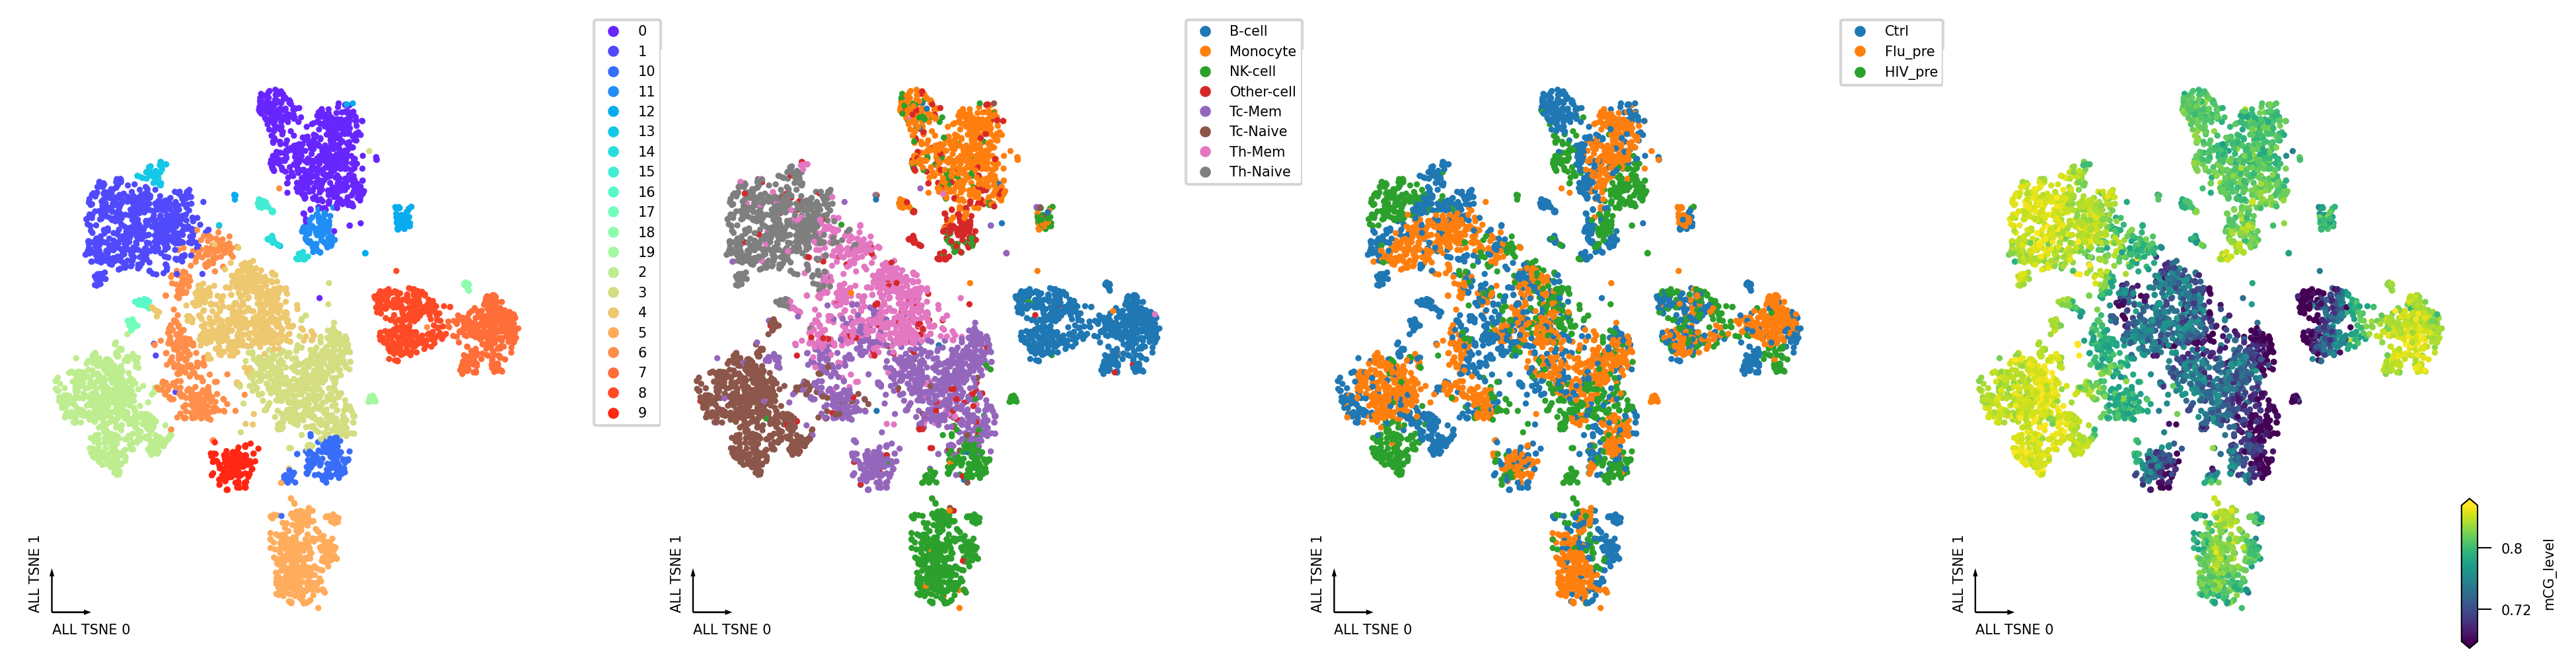

In [316]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
axes = axes.flatten()
_ = categorical_scatter(data=mcad.obs, ax=axes[0], coord_base='all_tsne', hue='all_leiden', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=mcad.obs, ax=axes[1], coord_base='all_tsne', hue='cell_type', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=mcad.obs, ax=axes[2], coord_base='all_tsne', hue='exposure', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = continuous_scatter(data=mcad.obs, ax=axes[3], coord_base='all_tsne', hue='mCG_level', labelsize=5)


### All cluster Harmony

In [317]:
sce.pp.harmony_integrate(mcad, 'exposure', max_iter_harmony=30, random_state=0)
mcad.obsm['5kCG_u30hm'] = mcad.obsm['X_pca_harmony'].copy()
sc.pp.neighbors(mcad, use_rep="5kCG_u30hm")
sc.tl.leiden(mcad, resolution=0.5)

tsne(mcad, obsm='5kCG_u30hm', metric='euclidean', exaggeration=-1, perplexity=30, n_jobs=10)
mcad = dump_embedding(mcad, 'tsne')
mcad.obs['HM_tsne_0'] = mcad.obs['tsne_0']
mcad.obs['HM_tsne_1'] = mcad.obs['tsne_1']
mcad.obs['HM_leiden'] = mcad.obs['leiden']

mcad.obsm['5kCG_u30hm_tsne'] = mcad.obsm['X_tsne'].copy()

2022-06-07 17:01:02,352 - harmonypy - INFO - Iteration 1 of 30
2022-06-07 17:01:53,888 - harmonypy - INFO - Iteration 2 of 30
2022-06-07 17:02:47,215 - harmonypy - INFO - Iteration 3 of 30
2022-06-07 17:03:39,668 - harmonypy - INFO - Converged after 3 iterations


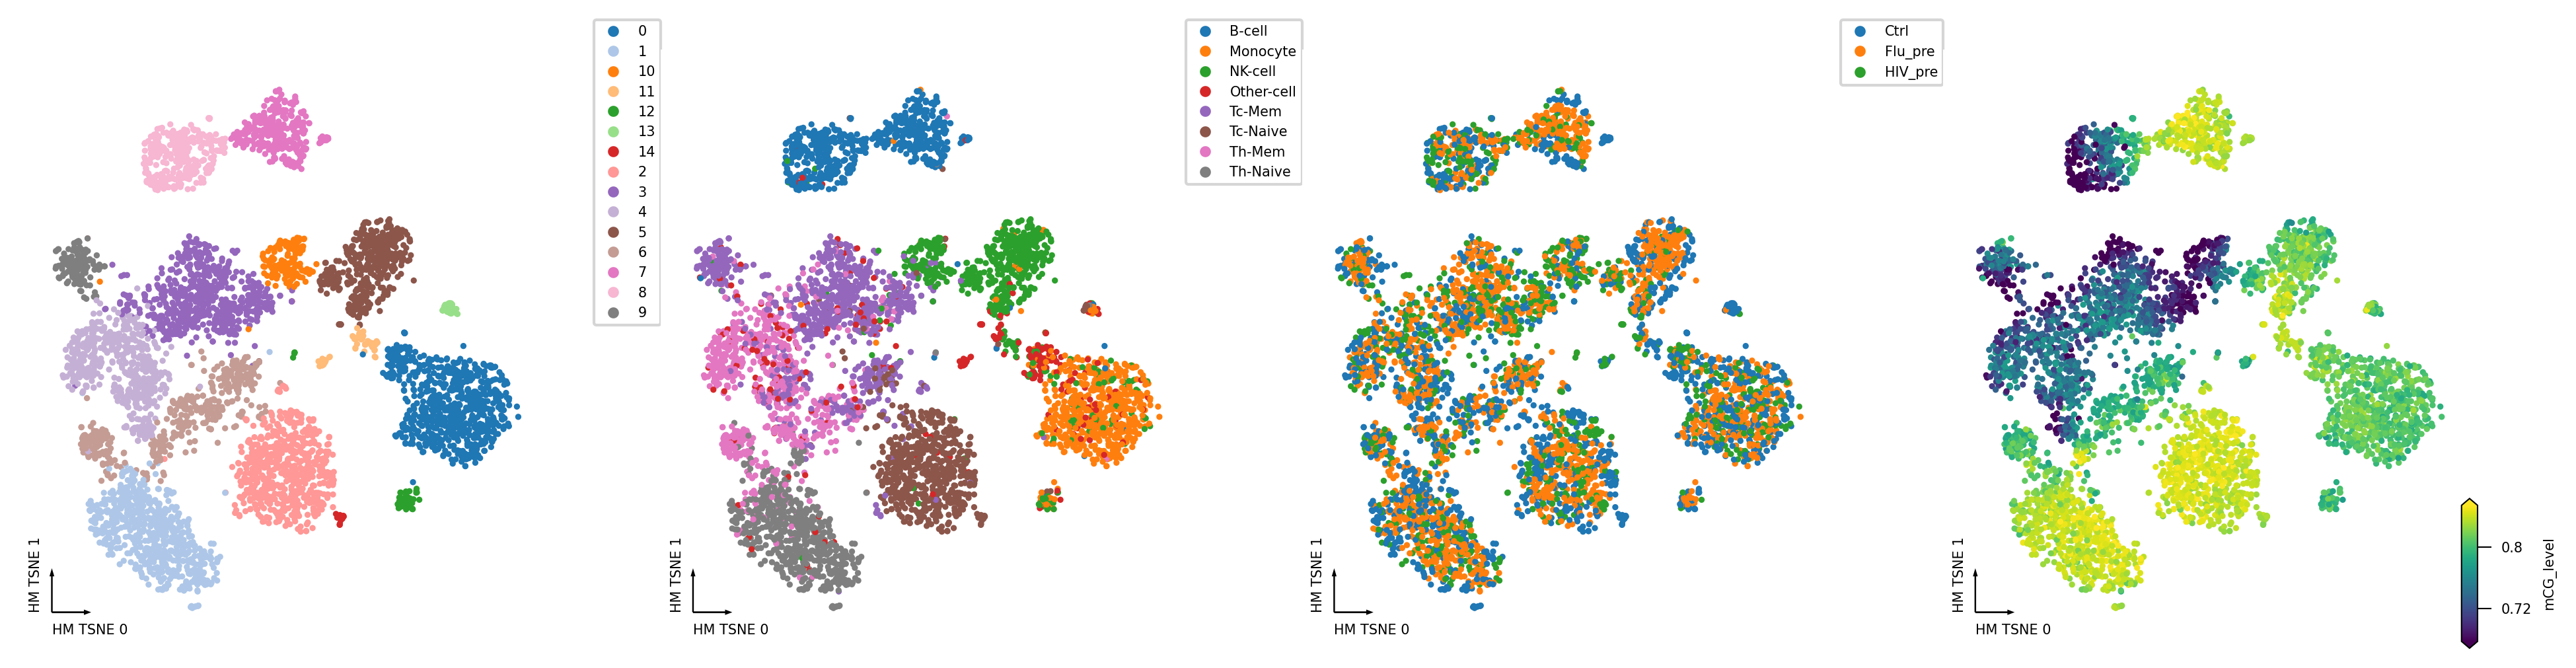

In [318]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
axes = axes.flatten()
_ = categorical_scatter(data=mcad.obs, ax=axes[0], coord_base='HM_tsne', hue='HM_leiden', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5, sizes=0.01)
_ = categorical_scatter(data=mcad.obs, ax=axes[1], coord_base='HM_tsne', hue='cell_type', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=mcad.obs, ax=axes[2], coord_base='HM_tsne', hue='exposure', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = continuous_scatter(data=mcad.obs, ax=axes[3], coord_base='HM_tsne', hue='mCG_level', labelsize=5)
plt.savefig("01.clustering/all_cluster.HM.pdf")

In [319]:
mcad.write("HIVpre_Flupre_Ctrl.All.TSNE.HM.h5ad")

In [3]:
leiden2celltype = {0: 'Monocyte',
                  5: 'NK-cell2',
                  7: 'B-Naive',
                  8: 'B-Mem',
                  10: 'NK-cell1'}

In [4]:
mcad.obs['annotation'] = mcad.obs.apply(lambda row: leiden2celltype[int(row['HM_leiden'])] if int(row['HM_leiden']) in leiden2celltype else row['cell_type'], axis=1)

In [5]:
mcad.obs

batch index_name  MultiplexReadsTotal  \
cell                                                                
HIV_1_R1_A0_Other-cell_pre      3      ad001           34255590.0   
HIV_1_R1_B0_Other-cell_pre      3      ad002           34255590.0   
HIV_1_R1_A1_Other-cell_pre      3      ad004           34255590.0   
HIV_1_R1_B1_Other-cell_pre      3      ad006           34255590.0   
HIV_1_R1_A18_Other-cell_pre     3      ad001           22259358.0   
...                           ...        ...                  ...   
Flu_9_1-6-M14-O12               5        NaN                  NaN   
Flu_9_1-6-M14-O23               5        NaN                  NaN   
Flu_9_1-6-M14-O24               5        NaN                  NaN   
Flu_9_1-6-M14-P12               5        NaN                  NaN   
Flu_9_1-6-M14-P24               5        NaN                  NaN   

                             IndexReadsTotal  IndexReadsRatio  IndexBpTotal  \
cell                                                                          
HIV_1_R1_A0_Other-cell_pre         4031068.0        11.767621   579804493.0   
HIV_1_R1_B0_Other-cell_pre         5012910.0        14.633845   720556253.0   
HIV_1_R1_A1_Other-cell_pre         5243094.0        15.305806   754961219.0   
HIV_1_R1_B1_Other-cell_pre         5587534.0        16.311306   798640481.0   
HIV_1_R1_A18_Other-cell_pre        3436418.0        15.438082   495537925.0   
...                                      ...              ...           ...   
Flu_9_1-6-M14-O12                        NaN              NaN           NaN   
Flu_9_1-6-M14-O23                        NaN              NaN           NaN   
Flu_9_1-6-M14-O24                        NaN              NaN           NaN   
Flu_9_1-6-M14-P12                        NaN              NaN           NaN   
Flu_9_1-6-M14-P24                        NaN              NaN           NaN   

                             IndexTrimedBpTotal  IndexTrimedReadsTotal  \
cell                                                                     
HIV_1_R1_A0_Other-cell_pre          496571353.0              3920896.0   
HIV_1_R1_B0_Other-cell_pre          616844650.0              4864419.0   
HIV_1_R1_A1_Other-cell_pre          646710720.0              5103260.0   
HIV_1_R1_B1_Other-cell_pre          682753797.0              5390298.0   
HIV_1_R1_A18_Other-cell_pre         424492938.0              3357457.0   
...                                         ...                    ...   
Flu_9_1-6-M14-O12                           NaN                    NaN   
Flu_9_1-6-M14-O23                           NaN                    NaN   
Flu_9_1-6-M14-O24                           NaN                    NaN   
Flu_9_1-6-M14-P12                           NaN                    NaN   
Flu_9_1-6-M14-P24                           NaN                    NaN   

                             ReadsQualTrimBpTotal  ReadsLengthFilterTotal  \
cell                                                                        
HIV_1_R1_A0_Other-cell_pre              1127041.0                110172.0   
HIV_1_R1_B0_Other-cell_pre              1414577.0                148491.0   
HIV_1_R1_A1_Other-cell_pre              1400092.0                139834.0   
HIV_1_R1_B1_Other-cell_pre              1497622.0                197236.0   
HIV_1_R1_A18_Other-cell_pre             1220161.0                 78961.0   
...                                           ...                     ...   
Flu_9_1-6-M14-O12                             NaN                     NaN   
Flu_9_1-6-M14-O23                             NaN                     NaN   
Flu_9_1-6-M14-O24                             NaN                     NaN   
Flu_9_1-6-M14-P12                             NaN                     NaN   
Flu_9_1-6-M14-P24                             NaN                     NaN   

                             ...  ct_tsne_0  ct_tsne_1    ct_leiden  \
cell                         ...                                  

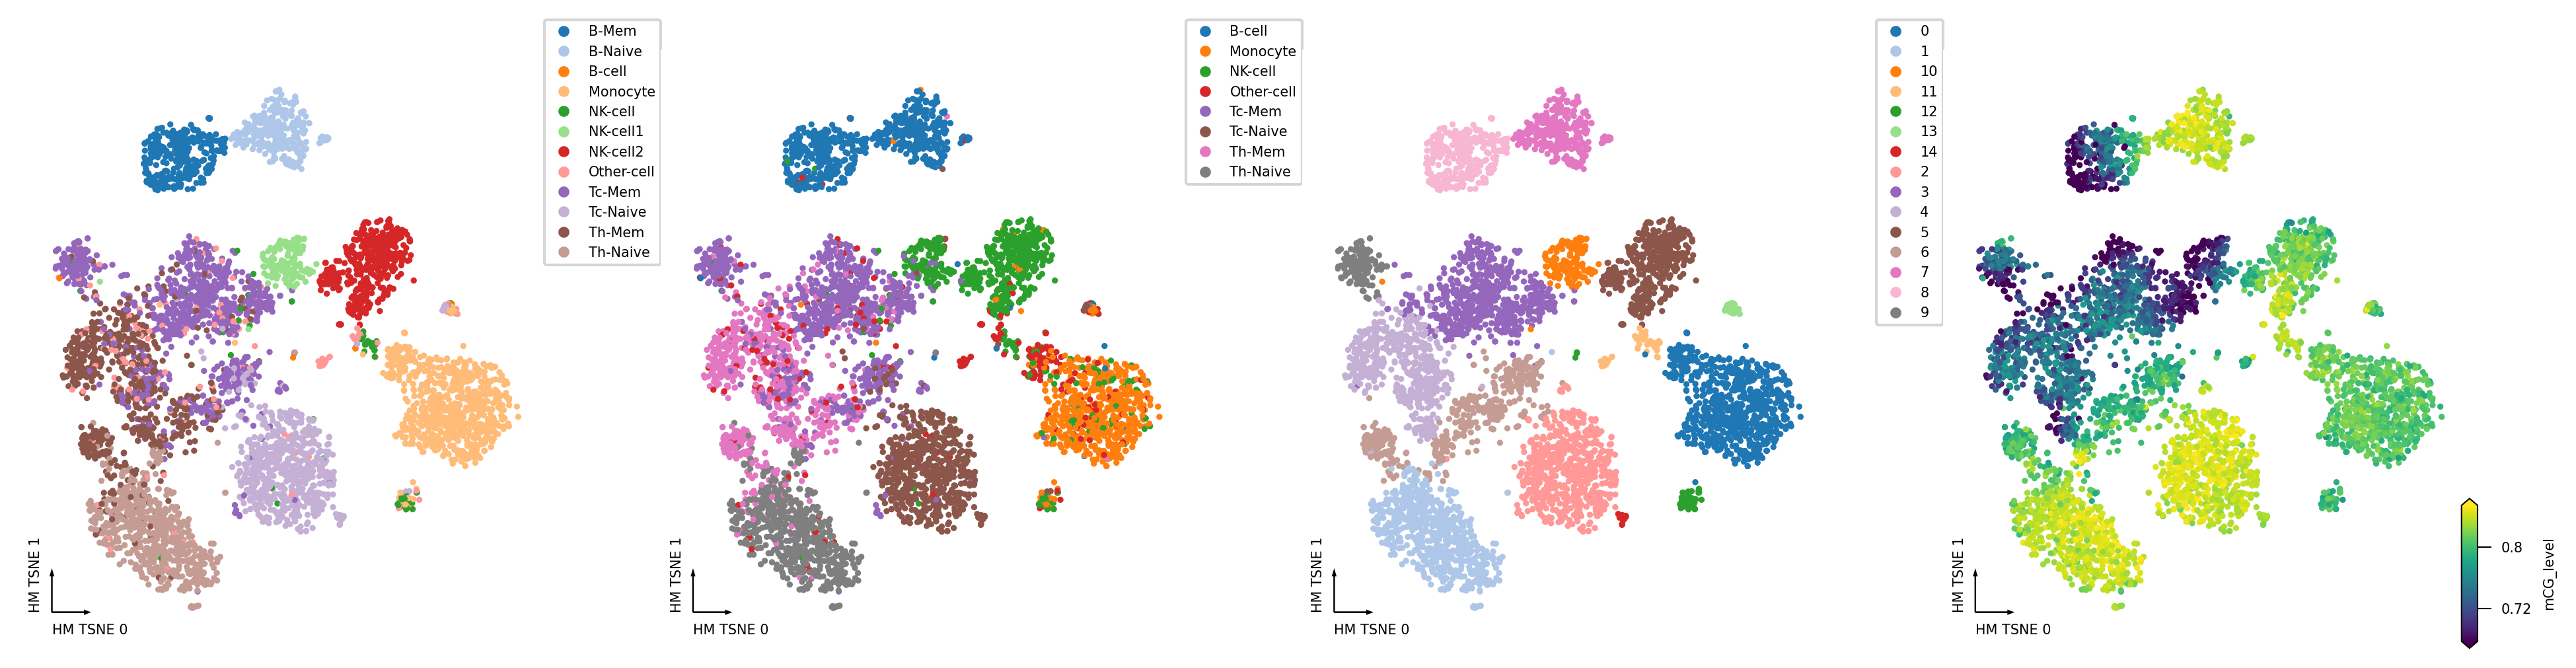

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
axes = axes.flatten()
_ = categorical_scatter(data=mcad.obs, ax=axes[0], coord_base='HM_tsne', hue='annotation', show_legend=True, 
                        legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
#                             text_anno="HM_leiden")
_ = categorical_scatter(data=mcad.obs, ax=axes[1], coord_base='HM_tsne', hue='cell_type', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=mcad.obs, ax=axes[2], coord_base='HM_tsne', hue='HM_leiden', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = continuous_scatter(data=mcad.obs, ax=axes[3], coord_base='HM_tsne', hue='mCG_level', labelsize=5)
plt.savefig("01.clustering/all_cluster.HM.anno.pdf")

In [7]:
mcad.write_h5ad("HIVpre_Flupre_Ctrl.All.TSNE.HM.Annotate.h5ad")

/gale/netapp/DoD/wenliang/bin/miniconda3/envs/echo/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'annotation' as categorical


In [8]:
mcad.obs.to_csv("ControlCell2cluster.csv")